# Homework 6: N-Gram Language Models with the Brown Corpus

## Due: Midnight on October 12th @ Midnight (with 2-hour grace period) and worth 85 points. 

## As announced, I'll not start to count late days until midnight on 10/13 (with same grace period). 

In this assignment you’ll practice **probabilistic language modeling (PLM)** by building N-Gram models that generate text. Along the way, you’ll develop the core pieces of a language model: estimating probabilities, calculating sentence likelihoods, and generating text with different strategies. The goal is to understand *how simple statistical models can produce coherent language*, and to explore refinements that make them more expressive.

### Learning Objectives

* Build and compare **unigram, bigram, and trigram** language models.
* Calculate **word and sentence probabilities** (in log-space) and use them to measure **perplexity**.
* Implement **probability-based generation** methods, including temperature-scaled sampling.
* Explore **beam search** as a way to generate higher-quality sentences.

### The four problems (high level)

1. **Problem 1 — N-Gram probabilities:**
   Build unigram, bigram, and trigram models. Compute next-word probabilities in log space to avoid numerical underflow.

2. **Problem 2 — Sentence probability & perplexity:**
   Define sentence probability, normalize for sentence length, and calculate perplexity as a measure of model quality.

3. **Problem 3 — Controlled generation:**
   Implement temperature-controlled sampling to vary randomness in generated sentences. Compare low vs. high temperatures.

4. **Problem 4 — Beam search:**
   Use perplexity to guide **beam search**, keeping track of the most likely candidate sentences at each step, and compare outputs to greedy generation.

By the end, you’ll have a working N-Gram generator capable of producing reasonable and a solid understanding of how early probabilistic approaches to NLP laid the foundation for modern deep learning methods.



### Recommended Workflow (Must Read!)

One of the most important skills in machine learning is following a **disciplined workflow** when developing complex code. The basic idea is simple:

1. **Start small:** Write and test your code using a tiny subset of your dataset.
2. **Inspect your results:** Print out and examine intermediate outputs to verify that each step behaves as expected.
3. **Iterate and tune:** Adjust hyperparameters and continue testing, gradually increasing the subset size as needed.
4. **Scale up:** Once you are confident your code is bug-free and your hyperparameters are roughly correct, run it on the **full dataset** to obtain your final results.

If you don’t have sufficient computing resources for a full run, use **as large a subset as practical** — provided you’ve begun early enough to allow for multiple iterations.


To help you follow this workflow in this homework, I’ve included a variable `num_sentences` that controls how many sentences are used from the shuffled Brown Corpus.

I recommend the following progression:

* **Step 1:** Begin with `num_sentences = 10` to debug and print out intermediate data structures (such as dictionaries) to confirm that your code works as expected.
* **Step 2:** Increase to `num_sentences = 100` to verify correctness and complete most of the homework efficiently.
* **Step 3:** Finally, if possible, run with the full dataset (`num_sentences = 57_340`), or as large a subset as your resources allow, to answer the graded questions.


There are 9 problems in this homework, each worth 9 points each, and you get 4 points free if you otherwise complete the homework. 

#### Useful Imports (add more as needed)

In [1]:
import math
import re
import string
import random
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

random.seed(42)

In [28]:
'''
Reconstruct a human-readable sentence from tokens.
- Capitalize the first token (after removing <s>).
- Attach any token in string.punctuation with no preceding space.
- Attach tokens starting with an apostrophe (e.g., "'s", "'ll") with no space.
- Capitalize standalone 'i' and 'god' wherever they appear.
- If the last token is '.', '?', or '!', attach it without a space.
- Ignore boundary markers <s> and </s> if present.
Returns the sentence string and also prints it depending on flag parameter.
'''

def print_sentence(tokens, do_print=True):

    if not tokens:
        print("")
        return ""

    # Drop boundary markers if present
    start = 1 if tokens and tokens[0] == "<s>" else 0
    end = -1 if tokens and tokens[-1] == "</s>" else len(tokens)
    core = tokens[start:end]

    if not core:
        print("")
        return ""

    # Capitalize first token
    out = core[0].capitalize()

    # Process remaining tokens with spacing rules
    for i, t in enumerate(core[1:], start=1):
        is_last = (i == len(core) - 1)

        # Last-token punctuation rule
        if is_last and t in {".", "?", "!"}:
            out += t
            continue

        # General punctuation attaches with no space (e.g., ',', ':', ';', ')', etc.)
        if t in string.punctuation:
            out += t
            continue

        # Apostrophe-start tokens like "'s", "'d", "'ll"
        if t.startswith("'"):
            out += t
            continue

        # Capitalize special standalone words
        if t.lower() in {"i", "god"}:
            out += " " + t.capitalize()
            continue

        # Default: add a space before normal words
        out += " " + t

    if do_print:
        print(out)
    return out


### Read in the list of all sentences in the Brown Corpus and process using SPaCy.

In [5]:
# Must do this the first time to get the Natural Language ToolKit

# !pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [7]:
import nltk
from nltk.corpus import brown
import spacy

nltk.download('brown')

# Get all Brown corpus sentences as raw text
# Brown is organized into categories, we flatten it into one list of sentences and shuffle
# so we can create a shorter list for testing

brown_texts = [" ".join(sent) for sent in brown.sents()]

random.shuffle(brown_texts)

# Brown has 57_340 sentences, set `num_sentences` to 1000 or smaller for testing

# num_sentences = 57_340
num_sentences = 10                           # <<<<<=====    Here is where you can change the size of the dataset

brown_texts = brown_texts[:num_sentences]

# Load spaCy English pipeline
nlp = spacy.load("en_core_web_sm")

# Process with spaCy: tokenize + sentencize
docs = list(nlp.pipe(brown_texts, disable=["ner", "tagger", "parser"]))  

# Each doc is one sentence; extract tokens and add beginning and ending tokens <s> ... </s>
tokenized_sentences = [ ['<s>'] + [token.text.lower() for token in doc if not token.is_space] + ['</s>'] for doc in docs ]

[nltk_data] Downloading package brown to
[nltk_data]     /Users/waynesnyder/nltk_data...
[nltk_data]   Package brown is already up-to-date!


#### If you have trouble downloading this...


I have uploaded a file `brown_sentences.txt` to a Google Drive folder which anyone with the link can read, just
uncomment the code in the next cell and run it:

In [ ]:
'''
import re, requests, random, spacy

# Paste the shared Drive link (no need to change anything else)
link = "https://drive.google.com/file/d/1f_BkNDF0ny11Tn4D4jsOoXhgPSUCHKlf/view?usp=drive_link"

# --- Convert to direct download URL ---
def get_direct_download_url(link):
    match = re.search(r"/d/([a-zA-Z0-9_-]+)", link) or re.search(r"id=([a-zA-Z0-9_-]+)", link)
    if not match:
        raise ValueError("Could not extract file ID from the link.")
    file_id = match.group(1)
    return f"https://drive.google.com/uc?export=download&id={file_id}"

url = get_direct_download_url(link)

# --- Download and prepare the text ---
response = requests.get(url)
lines = response.text.strip().split("\n")

random.shuffle(lines)


# Etc as before
'''

In [8]:
print("Number of sentences:", len(tokenized_sentences))
print("First sentence:      ",end='')
print_sentence(tokenized_sentences[0])
print("Tokenized sentence: ",end='') 
print(tokenized_sentences[0])

Number of sentences: 57340
First sentence:      The hearst men say that if hearst is nominated, he and his immediate friends will contribute to the democratic national committee the sum of$ 1,500,000.
Tokenized sentence: ['<s>', 'the', 'hearst', 'men', 'say', 'that', 'if', 'hearst', 'is', 'nominated', ',', 'he', 'and', 'his', 'immediate', 'friends', 'will', 'contribute', 'to', 'the', 'democratic', 'national', 'committee', 'the', 'sum', 'of', '$', '1,500,000', '.', '</s>']


### A Little EDA....

In [9]:
# Flatten tokens (exclude spaces)
all_tokens = [tok.text.lower() for sent in docs for tok in sent if not tok.is_space]

# Define "word": alphabetic, or alphabetic after removing internal apostrophes
def is_word(tok):
    s = tok.text
    return s.isalpha() or s.replace("'", "").isalpha()

# Extract words using the definition above
words = [
    tok.text.lower()
    for sent in docs
    for tok in sent
    if not tok.is_space and is_word(tok)
]

# Counts
num_chars = sum(len(s) for s in brown_texts)   # or len(text) if you started from one big text
num_tokens = len(all_tokens)
num_unique_tokens = len(set(all_tokens))
num_sentences = len(docs)
num_words = len(words)
num_unique_words = len(set(words))

print(f"Total number of characters in the text: {num_chars:,}")
print(f"Total number of tokens:    {num_tokens:,}")
print(f"Number of unique tokens:   {num_unique_tokens:,}")
print(f"Total number of sentences: {num_sentences:,}")
print(f"Total number of words:     {num_words:,}")
print(f"Number of unique words:    {num_unique_words:,}")

# Frequencies
word_counts = Counter(words)
most_common_words = word_counts.most_common()

# Top 10
print("\nTop 10 words:")
for token, freq in most_common_words[:10]:
    print(f"{token:<15}: {freq:,}")

# Bottom 10
print("\nBottom 10 words:")
for token, freq in most_common_words[-10:]:
    print(f"{token:<15}: {freq:,}")

Total number of characters in the text: 6,069,734
Total number of tokens:    1,198,833
Number of unique tokens:   43,320
Total number of sentences: 57,340
Total number of words:     1,017,681
Number of unique words:    41,455

Top 10 words:
the            : 70,003
of             : 36,473
and            : 28,916
to             : 26,241
a              : 23,259
in             : 21,419
that           : 10,789
is             : 10,206
was            : 9,969
he             : 9,801

Bottom 10 words:
mettwurst      : 1
bratwurst      : 1
bockwurst      : 1
knackwurst     : 1
pepperoni      : 1
blutwurst      : 1
burford        : 1
byer           : 1
barium         : 1
vrilium        : 1


### Digression: Zipf's Law

Zipf's Law is an empirical regularity of natural language:  
if you rank words by their frequency in a corpus, the frequency \( f(r) \) of the word at rank \( r \) is approximately inversely proportional to its rank:

$$
f(r) \propto \frac{1}{r^k}
$$

where $ r = 1, 2, 3, \dots $ is the rank of a word (1 = most frequent), and $ k \approx 1 $.  

- The most common words (e.g., *the*, *of*, *and*) occur very often.  
- A handful of mid-ranked words occur moderately often.  
- The vast majority of words occur rarely.  

On a **log–log plot** of frequency vs. rank, this relationship appears as a straight line with slope \(-k\).  
For natural language, empirical studies show that $k \approx 1$, which is why we plot below a reference line with slope $-1$ to compare against real corpus data.


**Why this matters:** Because most words are rare, language models must use techniques like **smoothing, subword modeling, or embeddings** to handle sparsity and represent meaning effectively.  


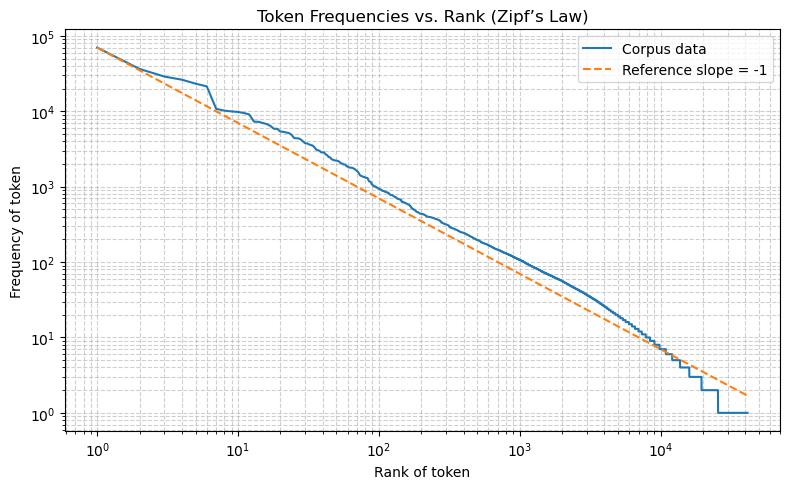

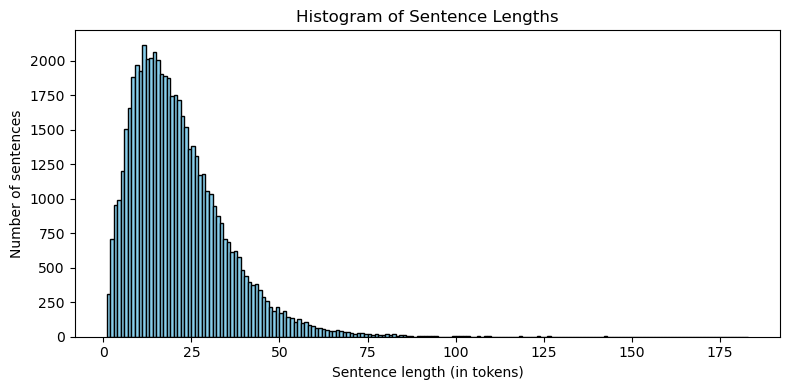

Average sentence length: 20.91 tokens
Max sentence length:     182 tokens


In [10]:
# Frequencies sorted by rank
freqs = np.array([freq for token, freq in word_counts.most_common()])
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(8, 5))
plt.plot(ranks, freqs, label="Corpus data")

# Reference line: slope = -1 (Zipf’s law)
# Match scale by anchoring at the first frequency
ref_line = freqs[0] / ranks
plt.plot(ranks, ref_line, "--", label="Reference slope = -1")

plt.xscale("log")
plt.yscale("log")
plt.title("Token Frequencies vs. Rank (Zipf’s Law)")
plt.xlabel("Rank of token")
plt.ylabel("Frequency of token")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Compute sentence lengths from spaCy docs
sentence_lengths = [len([tok for tok in sent if not tok.is_space]) for sent in docs]

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(
    sentence_lengths,
    bins=range(1, max(sentence_lengths) + 2),
    color="skyblue",
    edgecolor="black"
)
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence length (in tokens)")
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.show()

print(f"Average sentence length: {sum(sentence_lengths)/len(sentence_lengths):.2f} tokens")
print(f"Max sentence length:     {max(sentence_lengths)} tokens")

## Problem One — Build the PLM (bigrams & trigrams)

For this problem, you must adapt (mostly cut-and-paste) the code from this week’s Coding Notebook to the new dataset. You are using a trigram model as well as bigrams but your professor has written code that should mostly work for any N. 

We provide a pre-processed dataset above, with sentences already tokenized and enclosed in the boundary tokens `<s>` and `</s>`.

**Set `num_sentences=10` to start!**

**ToDo:**

**A.** Build N-grams for N = 2, 3

- Compute all bigrams and trigrams over the tokenized sentences (boundary tokens included).

**B.** Create a dictionary mapping left-contexts to next-word lists

- For each N, map each context (length N−1) to a list of next tokens (allow duplicates so frequency = count).

**C.** Convert to (log) probability distributions

- Turn each context’s next-word list into a distribution of log-probabilities (see **Appendix Two**).

**D.** Create the Probability Language Model (PLM)

- Create a dictionary `get_next_word` with:

    - Key: left context (tuple of 1 token for bigrams; 2 tokens for trigrams).
    
    - Values: nested dictionary mapping next tokens to log-probabilities `{next_token: log_prob, ...}`.

- Create a **single dictionary** (since bigrams and trigrams have a left context of different lengths, and they won't get confused in the dictionary).


**E.** Set the variable `num_sentences = 10` and do a sanity check by displaying the distribution for the bigram contexts e.g., `('<s>',)` and `('the',)` and a trigram context `('<s>','the')`. If for some reason these are not present, increase the number of sentences slightly.  

**F.**  Generate 5 next words for each of the 3 examples in the previous part. 

**Then answer the graded questions.**

In [52]:
# Your code here (add as many cells as you need)


### Graded Question:

In the next cell, set `a1` to the list of 5 next words for the trigram context `('<s>','the')` (unlikely, but you may have to adjust `num_sentences` as indicated). 

In [53]:
# Your answer here

a1 = []

In [54]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1 in this problem         

print(f'a1 = {a1}') 


a1 = []


## Problem Two: Generating Sentences with Backoff and Temperature


The algorithm for generating sentences from a N-Gram PLM is simple: look at the last $N-1$ tokens of the sentence and use the probability distribution of next words to select the continuation word; stop when you generate `'</s>'`. 


For **bigrams**, this works well: Every token in the text is followed by another token (because `</s>` ends every sentence). 

However there are two problems when using N-grams for $N>2$: 

**1. Cold Start (not enough left-context):**  You don't have enough left context in the beginning, so you start with what you have until you have enough left context.   For example, with trigrams:

                                          Find next word using:
        Step 1:    <s> ?                      bigrams
         context:  ---
        Step 2:    <s> One ?                  trigrams
         context:  ------
        Step 3:    <s> One ish ?             continue on with trigrams
         context:      ---------


**2. Sparsity (not enough N-grams):** For bigrams we always have a continuation for the left context (1 token). However, it is possible for $N>2$ that there is no N-gram which gives you a choice of next words, for example, suppose your sentence so far is

            "One fish dish ..."

and there is no trigram in the form `("fish", "dish", ...)`. In this case we use the **backoff** strategy: if there is no trigram left-context `("fish", "dish")`, 
cut out one token and use the (safe) bigram strategy with left context `("dish",)`.  In general, for any $N$, 
if $N$ does not provide a next word, try $N-1$, $N-2$ etc. until one is found (in the worse case,
for $N=1$, you'll just select a likely word without any left-context, but note that with boundary tokens, you'll
always have a bigram). 


**ToDo:**

- Adapt the code for generating sentences from the Coding Video to perform the backoff strategy just described, and using your code from Problem One.
- Make sure you convert the log probabilities **back into non-log probabilities before you use them as weights in in `np.choice(..., p=weights)`**.
- Perform 3 experiments with temperature set at 0.2, 1.0, and 5.0 **with the full dataset if possible**:
    - Generate 10 sentences for each temperature, print them out using `print_sentence` and observe whatever differences you can. 
- Answer the graded questions. 

In [55]:
# Your code here (add as many cells as you need)


### Graded Questions:

#### Part 2A: In the next cell, set `a2a` to the *most realistic sentence* generated (your call!). Use `print_sentence(..., do_print=False)`. 

In [56]:
# Your answer here

a2a = ''

In [57]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a2a in this problem         

print(f'a2a = {a2a}') 


a2a = 


#### Part 2B:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which seemed to produce the most realistic sentences?

Your answer here:



## Problem Three:  Measuring the Quality of Sentences:  Average Log Probability and Perplexity

The probabilities involved when we start to calculate the probability of longer token sequences are extremely small, and underflow is common
for a large corpus. Therefore we calculate all probabilities in **log space** (see **Appendix Two** for an explanation). 

Basically, the quality metric for generated sentences is likelihood: If a sentence is more probable, it is better. 
However, this metric is biased towards short sentences, since we multiply the probabilities of each word,
and long sentences end up being very unlikely. But natural language does not behave this way!

Therefore, we will remove the length from the calculation using the following measures:

**Average of Log Probabilities (ALP)** is a length-agnostic measure of sentence probability. For trigrams:

Let the tokenized sentence be $[t_1,\ldots,t_n]$ with $t_1$ = `<s>` and $t_n$ = `</s>`.


$$
\text{ALP}([t_1, t_2, \dots, t_n]) 
\ =\ \frac{\log P(t_2 \mid t_1) + \log P(t_3 \mid t_1, t_2) + \dots + \log P(t_n \mid t_{n-2}, t_{n-1})}{n-1}
$$

**Notes:** 
- We don't include the first token because it is always present and hence not predicted; think of
it as a prompt which gets the sentence going!
- To account for backoff, simply use the log probability of the bigram in those cases instead of the trigram. 
- ALP is in $(-\infty \ldots 0.0]$ and larger is better.  It grows more negative as the model performs worse. 


**Perplexity** is the most common metric in NLP: it rescales the ALP into a more intuitive, positive scale:

> Perplexity = np.exp( - ALP ).     

Perplexities are $\ge 1.0$ and smaller is better.   A larger perplexity means the model is “more perplexed,” i.e., on average it is choosing among more equally likely alternatives.

Because the exponential is monotonic, minimizing perplexity is exactly the same as maximizing average log probability—so either metric may be used for ranking models, but perplexity is more commonly used by the NLP community. 

### Before You Start

You can compute ALP during generation by carrying **state** along with the partial sentence.
Instead of storing:

> tokens_so_far = [ `<s>`, $t_2$, $t_3$, … ]

store a **pair**:

> ( tokens_so_far, sum_log_probs)

where

* **sum_log_probs** = $( \log P(t_2\mid t_1) + \log P(t_3\mid t_1,t_2) + \cdots )$

In the case that backoff was used to generate some $t_k$, you just use $\log P(t_{k}\mid t_{k-1})$

Then your loop is:

1. Start with tokens = `['<s>']` and `sum_log_probs = 0.0`.
2. Get the left context (trigram preferred; back off to bigram if needed).
3. **Sample** the next token using temperature, but **score** with the model’s **true** log-prob for that token (un-tempered): update `sum_log_probs += log P(next|context)`.
4. Append the token; if it is `</s>`, stop, else repeat froms step 2. 
5. Calculate the perplexity of the completed sentence:
- Divide the running sum of log probabilities by `len(tokens)-1` to get the final ALP.
- Calculate `PP = np.exp(-ALP)` and return the pair `( completed-list-of-tokens, PP)` as the generated sentence. 



### To Do

* Modify your `get_next_word` and sentence generator method to maintain `(tokens, sum_log)` as above and return `(tokens, Perplexity)`.
- Perform 3 experiments with temperature set at 0.2, 1.0, and 5.0 **with the full dataset if possible**:
    - Generate 10 sentences for each temperature, print them out using `print_sentence` and observe whatever differences you can, comparing them with the perplexity. 
* Answer the graded questions.


In [58]:
# Your code here: add as many cells as you wish



### Graded Questions:

#### Part 3A: In the next cell, set `a3a` to the sentence with the smallest perplexity. Use `print_sentence(..., do_print=False)`. 

In [59]:
# Your answer here

a3a = ''

In [60]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a3a
print(f'a3a = {a3a}') 


a3a = 


#### Part 3B:  Set `a3b` to the perplexity for the sentence you provided in Part 3A. 


In [61]:
# Your answer here

a3b = 0.0

In [62]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1 in this problem         

print(f'a3b = {a3b}') 


a3b = 0.0


#### Part 3C:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which produces the sentences with the best perplexity (you might want to take the average of all 10!). 

Your answer here:



## Problem Four:  Beam Search

For our final problem, we'll implement a common technique for searching for sentences with low perplexity. 

**Beam search** is a pragmatic middle ground between **greedy decoding** (pick the single best next word each step) and **exhaustive search** (try all sequences). 

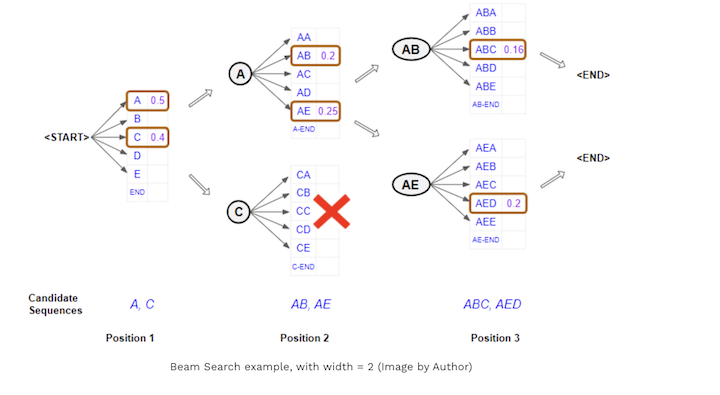

The basic idea is reasonably simple:

Maintain a list of at most **B** incomplete sentences, sorted in **decreasing order of their ALP (best at the top)**; you'll need to calculate this during the sort, or perhaps store a triple 
> (list-of-tokens, sum-of-log-probs, ALP-so-far)

where 
> ALP-so-far =sum-of-log-probs/(len(list-of-tokens)-1)

Populate this priority queue with **B** bigrams (continuations of the start symbol).

In each loop:

1. Generate **C** continuations of each of the partial-sentences in the queue and add them to the queue and sort it again. 
2. Remove any completed sentences, calculate their perplexity and store them in a separate list `Finished`. 
3. Delete all but the best **B** candiates.
4. Repeat from step 1 until you get 10 finished sentences in `Finished`. 
5. Sort the list `Finished` in increasing order of perplexity (best at top) and print it out. 

  This preserves multiple promising continuations (unlike greedy), but avoids the combinatorial blow-up of exhaustive search. Using **log-probs** makes scoring stable; using a **length-normalized** score (ALP) prevents the search from favoring short fragments. Beam width (B) controls the trade-off: larger (B) explores more but costs more time and can still prune good paths too early. Continuation width (C) controls how widely you search possible continuations, and uses temperature. 

**ToDo:**

- Implement beam search as described, using $B=C=5$ (feel free to try other settings). 
- Experiment with temperatures of 0.2, 1.0, and 5.0 as before.
- Print out your finished sentences with perplexities.
- Answer the graded questions. 

In [63]:
# Your code here; add as many cells as you wish



### Graded Questions:

#### Part 4A: In the next cell, set `a4a` to the sentence with the smallest perplexity generated by beam search. Use `print_sentence(..., do_print=False)`. 

In [64]:
# Your answer here

a4a = ''

In [65]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a3a
print(f'a4a = {a4a}') 


a4a = 


#### Part 4B:  Set `a4b` to the perplexity for the sentence you provided in Part 4A. 


In [66]:
# Your answer here

a4b = ''

In [67]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a4b in this problem         

print(f'a4b = {a4b}') 


a4b = 


#### Part 4C:  Describe in a few sentences what you observed with the different temperature settings (and try more if you wish!). Which produces the sentences with the best perplexity (you might want to take the average of all 5!). 

Your answer here:



## Appendix One: The Brown Corpus

The **Brown Corpus of Standard American English** was compiled at **Brown University** by W. Nelson Francis and Henry Kučera in 1961. It was the **first electronic, balanced corpus of English** ever created and contains about **one million words** drawn from **500 written texts** published in the United States in 1961.

At the time, this was groundbreaking: instead of studying isolated examples, linguists and computer scientists could analyze the **statistical properties of language** across many genres. The Brown Corpus became a **benchmark dataset** in early computational linguistics, psycholinguistics, and later in natural language processing.

### Genres in the Brown Corpus

The 500 texts were divided evenly across **15 categories**, each representing a different register or style of writing:

* **Press**: reportage, editorials, reviews
* **General prose**: popular lore, belles lettres, essays
* **Fiction**: adventure, romance, science fiction, mystery, humor
* **Learned writing**: academic and scientific publications
* **Religious writing**: sermons, expository texts
* **Skills and hobbies**: manuals, do-it-yourself, gardening, sports writing
* **Government documents**: official reports, public affairs writing
* **Miscellaneous**: popularized non-fiction, biography

Each category contributes about 2,000 sentences (roughly 80,000 words), ensuring a **balanced sample** of contemporary written English.

### Examples of Source Texts

While the Brown Corpus does not preserve full books in sequence, the selections were drawn from published works of the time. Examples include:

* **Fiction**: pulp magazines, detective novels, romance stories, humorous fiction.
* **Press**: articles from major U.S. newspapers and magazines such as *Time* and *Newsweek*.
* **Religion**: sermons, Bible commentary, religious essays.
* **Academic**: journal articles in history, sociology, psychology, and linguistics.
* **Skills and hobbies**: popular magazines like *Popular Mechanics* and *Field & Stream*.

The corpus thus reflects a **snapshot of American English in 1961**: how it was written in popular culture, journalism, science, religion, and government.

### Why It Matters

* **Historical importance**: the first large corpus, setting the stage for all later corpus linguistics.
* **Balanced design**: unlike modern web scrapes (e.g., Wikipedia), Brown was carefully curated to capture a **cross-section of genres**.
* **Still used today**: it remains a teaching resource for exploring **word frequencies, n-grams, Zipf’s law, and stylistic differences across genres**.

### Categories in the Brown Corpus  

The Brown Corpus is divided into 15 genres, each with about 80,000 words (for a total of ~1 million). This balance makes it useful for studying stylistic and lexical variation across English.  

| Code | Category              | Description / Examples                                  |
|------|-----------------------|---------------------------------------------------------|
| A    | Press: Reportage      | Straight news reporting; newspaper and magazine articles |
| B    | Press: Editorial      | Opinion pieces and editorials from newspapers/magazines |
| C    | Press: Reviews        | Reviews of books, plays, music, films                   |
| D    | Religion              | Sermons, religious commentary, Bible studies            |
| E    | Skills & Hobbies      | How-to manuals, sports, leisure, do-it-yourself         |
| F    | Popular Lore          | Popular science, cultural essays, lore                  |
| G    | Belles Lettres        | Literary essays, non-fiction with artistic style        |
| H    | Miscellaneous         | Biographies, memoirs, other non-fiction                 |
| J    | Learned               | Academic and scientific writing                         |
| K    | General Fiction       | Short stories and novels, general fiction               |
| L    | Mystery & Detective   | Detective and crime fiction                             |
| M    | Science Fiction       | Science fiction stories and novels                      |
| N    | Adventure & Western   | Adventure stories, Westerns                             |
| P    | Romance               | Romantic fiction                                        |
| R    | Humor                 | Humorous fiction and essays                             |

Together these categories provide a **snapshot of American English in 1961**, from journalism and government reports to pulp fiction and academic writing.  


In [68]:
for p in [1,1/2,1/3,1/4, 0.01, 1e-10]:
          print(math.log(p))

0.0
-0.6931471805599453
-1.0986122886681098
-1.3862943611198906
-4.605170185988091
-23.025850929940457


## Appendix Two: Using Log-Probabilities in N-Gram Models

When working with **n-gram language models**, we calculate the probability of a sentence by multiplying the conditional probabilities of each word:

$$
P(w_1, w_2, \dots, w_n) = \prod_{i=1}^n P(w_i \mid \text{context})
$$

### Do we really need logs for the Brown Corpus?

In the Brown Corpus, the **longest sentence has 182 tokens**. That’s not very long compared to modern corpora, so you might think multiplying probabilities directly is fine. For example:

* If the average conditional probability were around $0.1$, the longest Brown sentence has probability about
  $$(0.1)^{182} = 10^{-182},$$
  which is still representable in double precision (smallest positive $\approx 10^{-324}$).

* But if the average probability were closer to $0.01$, then
  $$(0.01)^{182} = 10^{-364},$$
  which would **underflow to 0**.

So in some cases you’d be safe, in others not.

### Some Examples of Log Probabilities

Since probabilities are always in the range $[0,1.0]$, log probabilities are in the range $[-\infty,0.0]$. Here are
some examples of log probabilities (we'll use natural logs, but the base really doesn't matter):

    Probability         Log Probability
      1.0                 0.0
      1/2                -0.6931471805599453
      1/3                -1.0986122886681098
      1/4                -1.3862943611198906
      0.01               -4.605170185988091
      1e-10              -23.025850929940457
      1e-1000            -2302.5850929940457

(To put this in somewhat real terms, suppose you and a friend could both randomly choose an **atom** somewhere in the observable
universe: the probability that you both choose the same atom is approximately 1e-80.) 

### Why we use log-probabilities anyway

Even if underflow is not common in Brown sentences, there are three strong reasons to switch to log-space:

1. **Smoothing produces tiny probabilities.** With add-one or Kneser–Ney smoothing, many n-grams have very small values, making underflow more likely.
2. **Corpus-level calculations.** Perplexity is often computed over *all tokens* in the corpus. With Brown’s ~1M tokens, multiplying raw probabilities is completely impossible.
3. **Consistency with NLP practice.** Modern language models (n-gram and neural alike) always work in log-space. Teaching it here ensures the method scales to larger datasets like Shakespeare, WikiText, or web-scale corpora.

### The log-space trick

Recall how computing in log-space works:

- Convert your numbers to logs
- Instead of multiplying, add  
- Instead of exponentiation, multiply
- If you need to sort, or compare using $\lt$ or $\le$, just do it in log-space (since it is monotonic, i.e., preserves order)
- Convert back to normal if you want to print it out in human-readable form as a metric or use it with code that expects normal probabilities (e.g., softmax, or sampling). 

Thus, instead of multiplying probabilities, we sum log probabilities:

$$
\log P(w_1, w_2, \dots, w_n) = \sum_{i=1}^n \log P(w_i \mid \text{context})
$$

This prevents underflow, keeps values in a manageable numeric range, and makes computation easier.

* **Ranking:** For decoding or beam search, you can use log-probabilities directly, since $\log$ is monotonic. No conversion back is needed.
* **Perplexity:**

$$
\text{PP} = \exp\left(-\tfrac{1}{n} \sum_{i=1}^n \log P(w_i \mid \text{context})\right)
$$

Here the exponential is applied only at the end.

* **Sampling:** To draw the next word, convert log-probabilities back with `exp()` to normalize.

---

✅ **TL;DR Summary:** In the Brown Corpus, you *might* get away with raw probabilities for single sentences, but log-space is essential once you apply smoothing, compute perplexity over the whole corpus, or move to larger datasets. It’s also the standard method in NLP, so it’s best to learn it now.

